In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = 'cuda'

In [3]:
torch.manual_seed(42)

In [4]:
df = pd.read_csv('../../../3OEC_current_flow.csv')

df["O2_avg"] = df[["O2_S1", "O2_S2", "O2_S3"]].mean(axis=1)

In [45]:
def MARE(prediction_tensor, truth_tensor):
    epsilon = 1e-8  # Small value to prevent division by zero
    print(torch.abs((prediction_tensor - truth_tensor)) / torch.abs(truth_tensor + epsilon))
    return (torch.sum(torch.abs((prediction_tensor - truth_tensor)) / torch.abs(truth_tensor + epsilon))) / truth_tensor.numel()

In [6]:
from datetime import datetime, timedelta

start_time_11 = datetime(2017, 7, 11, 14, 0, 0)
end_time_11 = datetime(2017, 7, 12, 8, 0, 0)

start_time_13 = datetime(2017, 7, 13, 11, 0, 0)
end_time_13 = datetime(2017, 7, 14, 6, 0, 0)

start_time_15 = datetime(2017, 7, 15, 10, 0, 0)
end_time_15 = datetime(2017, 7, 16, 6, 0, 0)

start_time_16 = datetime(2017, 7, 16, 16, 0, 0)
end_time_16 = datetime(2017, 7, 17, 6, 0, 0)

deployments = {
    "3oec_2017_7_11_12": {"start": start_time_11, "end": end_time_11},
    "3oec_2017_7_13_14": {"start": start_time_13, "end": end_time_13},
    "3oec_2017_7_15_16": {"start": start_time_15, "end": end_time_15},
    "3oec_2017_7_16_17": {"start": start_time_16, "end": end_time_16}
}

date_ranges = []

for deployment_name, deployment_info in deployments.items():
    start_time = deployment_info["start"]
    end_time = deployment_info["end"]
    if deployment_name == "3oec_2017_7_13_14":
        start_time -= timedelta(seconds=0.125)
    print(start_time)

    # Calculate total seconds and number of measurements
    total_seconds = (end_time - start_time).total_seconds() + 0.125
    num_measurements = int(total_seconds * 8)

    # Create DatetimeIndex for the deployment
    date_range = pd.date_range(start=start_time, periods=num_measurements, freq=f'{1000/8}ms')
    print(date_range[0], date_range[-1])
    print(len(date_range))
    date_ranges.append(pd.Series(date_range))

# Concatenate all DatetimeIndexes
complete_index = pd.concat(date_ranges)

# Set the complete index to your DataFrame
df.index = complete_index

2017-07-11 14:00:00
2017-07-11 14:00:00 2017-07-12 08:00:00
518401
2017-07-13 10:59:59.875000
2017-07-13 10:59:59.875000 2017-07-14 06:00:00
547202
2017-07-15 10:00:00
2017-07-15 10:00:00 2017-07-16 06:00:00
576001
2017-07-16 16:00:00
2017-07-16 16:00:00 2017-07-17 06:00:00
403201


In [7]:
# drop deployment column and resample
df_resampled = df.drop(columns=['deployment', 't', 't_increase', 'Vx', 'Vy', 'Vz', 'P', 'O2_S1', 'O2_S2', 'O2_S3']).resample('5min').mean()

In [8]:
first_piece = df_resampled["2017-07-11":"2017-07-12 06:00:00"]
second_piece = df_resampled["2017-07-13 12:00:00":"2017-07-14 06:00:00"]
third_piece = df_resampled["2017-07-15 12:00:00":"2017-07-16 6:00:00"]
fourth_piece = df_resampled["2017-07-16 16:00:00":"2017-07-17"]

In [9]:
def create_sequences(data, seq_length):
    """
    Creates sequences and their corresponding target sequences from the input data.
    The target sequence is half the size of the training sequence.

    Args:
        data (array-like): The input data.
        seq_length (int): The length of each training sequence.

    Returns:
        np.ndarray: Array of input sequences.
        np.ndarray: Array of target sequences (half the length of input sequences).
    """

    sequences = []
    targets = []
    
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i+seq_length])                        # Input sequence
        targets.append(data[i+seq_length]) # Target is a single step

    return np.array(sequences), np.array(targets)


In [10]:
column_indices = {name: i for i, name in enumerate(first_piece.columns)}
n = len(first_piece)
train_df1 =first_piece[:int(n*0.8)]
val_df1 = first_piece[int(n*0.8):]


# Normalize the data (each partition separately)
train_mean1 = train_df1.mean()
train_std1 = train_df1.std()

train_df1 = (train_df1 - train_mean1) / train_std1
val_df1 = (val_df1 - train_mean1) / train_std1

# make sequences
train_seq1, train_labels1 = create_sequences(train_df1.values, 12)
val_seq1, val_labels1 = create_sequences(val_df1.values, 12)

# make tensors
train_seq_tensor1 = torch.FloatTensor(train_seq1).to(device=device)  # (batch, seq_length, input_dim)
train_label_tensor1 = torch.FloatTensor(train_labels1).to(device=device) # (batch, output_dim)
val_seq_tensor1 = torch.FloatTensor(val_seq1).to(device=device)  # (batch, seq_length, input_dim)
val_label_tensor1 = torch.FloatTensor(val_labels1).to(device=device)  # (batch, output_dim)

In [11]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_dim, output_dim)
        # self.do = nn.Dropout()
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial hidden state
        c0 = torch.zeros(self.num_layers, self.hidden_dim).to(x.device)  # Initial cell state
        
        out, _ = self.lstm(x, (h0, c0))
        # out = self.do(out)
        out = self.fc(out[-1, :])  # Take the last 30 time step output
        return out

# Model parameters
input_dim = 1
hidden_dim = 256
num_layers = 3
output_dim = 1

# Instantiate model
model1 = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)
model1 = model1.to(device)  # Use "cuda" if you have a GPU
# criterion1 = nn.SmoothL1Loss()
optimizer1 = optim.Adam(model1.parameters(), lr=1e-4)

In [12]:
num_epochs = 100
train_losses = []
val_losses = []
for epoch in range(num_epochs):

    for i in range(len(train_seq_tensor1)):
        model1.train()
    
        optimizer1.zero_grad()
        y_pred = model1(train_seq_tensor1[i])
        loss = MARE(y_pred, train_label_tensor1[i])
        # print(y_pred)
        # print(loss.item())
        loss.backward()
        optimizer1.step()
    
        train_losses.append(loss.item())

    # Validation
    model1.eval()
    
    if epoch % 10 == 0:
        with torch.no_grad():
            for i in range(len(val_seq_tensor1)):
                y_val = model1(val_seq_tensor1[i])
                val_loss = MARE(y_val, val_label_tensor1[i])
                val_losses.append(val_loss.item())
        print(f'Epoch {epoch}, Train Loss: {loss.item()}, Val Loss: {val_loss.item()}')


Epoch 0, Train Loss: 0.9953708648681641, Val Loss: 0.9928785562515259
Epoch 10, Train Loss: 0.8008239269256592, Val Loss: 0.7849471569061279
Epoch 20, Train Loss: 0.11016017198562622, Val Loss: 0.13534003496170044
Epoch 30, Train Loss: 0.06905316561460495, Val Loss: 0.07881635427474976
Epoch 40, Train Loss: 0.008965639397501945, Val Loss: 0.012003819458186626
Epoch 50, Train Loss: 0.024311546236276627, Val Loss: 0.002858807099983096
Epoch 60, Train Loss: 0.029987648129463196, Val Loss: 0.007713401690125465
Epoch 70, Train Loss: 0.006025306880474091, Val Loss: 0.01562984474003315
Epoch 80, Train Loss: 0.020688088610768318, Val Loss: 0.04144253954291344
Epoch 90, Train Loss: 0.04703123867511749, Val Loss: 0.12285877019166946


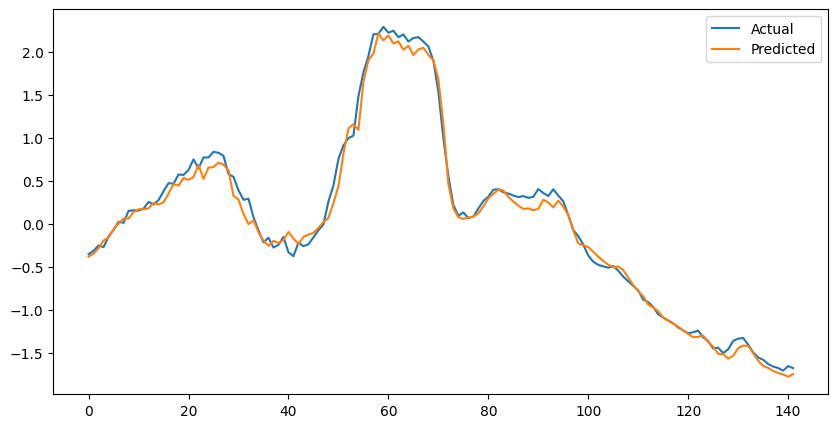

In [28]:
model1.eval()
y_pred = []
with torch.no_grad():
    for i in range(len(train_seq_tensor1)):
        pred = model1(train_seq_tensor1[i])
        y_pred.append(pred.cpu())

plt.figure(figsize=(10, 5))
plt.plot(train_label_tensor1.cpu().numpy(), label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [40]:
y_pred_t = torch.FloatTensor(y_pred).to(device='cuda')

print(y_pred_t)

tensor([-3.8244e-01, -3.4778e-01, -2.8527e-01, -1.9426e-01, -1.6067e-01,
        -6.1306e-02,  1.7073e-03,  6.0087e-02,  6.0762e-02,  1.3603e-01,
         1.6767e-01,  1.6825e-01,  1.7881e-01,  2.4216e-01,  2.2476e-01,
         2.4809e-01,  3.4955e-01,  4.6035e-01,  4.4271e-01,  5.3139e-01,
         5.0963e-01,  5.4202e-01,  6.8496e-01,  5.2000e-01,  6.5149e-01,
         6.5719e-01,  7.1036e-01,  6.8666e-01,  6.1940e-01,  3.2219e-01,
         2.8157e-01,  1.1319e-01, -5.7050e-03,  4.0307e-02, -9.9568e-02,
        -1.9652e-01, -2.5701e-01, -1.9974e-01, -2.2103e-01, -1.9141e-01,
        -9.5192e-02, -1.7169e-01, -2.3717e-01, -1.5207e-01, -1.2680e-01,
        -1.0649e-01, -4.9295e-02,  1.8176e-02,  6.6833e-02,  2.3856e-01,
         4.3730e-01,  8.0835e-01,  1.1062e+00,  1.1551e+00,  1.0904e+00,
         1.6442e+00,  1.8999e+00,  1.9759e+00,  2.2109e+00,  2.1301e+00,
         2.1852e+00,  2.0947e+00,  2.1177e+00,  2.0212e+00,  2.0676e+00,
         1.9590e+00,  2.0238e+00,  2.0436e+00,  1.9

In [37]:
train_label_tensor1.squeeze(1)

tensor([-0.3538, -0.3142, -0.2524, -0.2715, -0.1482, -0.0718,  0.0224,  0.0101,
         0.1489,  0.1558,  0.1518,  0.1759,  0.2520,  0.2236,  0.2740,  0.3778,
         0.4706,  0.4649,  0.5720,  0.5668,  0.6242,  0.7472,  0.6437,  0.7696,
         0.7696,  0.8346,  0.8236,  0.7883,  0.5784,  0.5439,  0.3894,  0.2781,
         0.2901,  0.0762, -0.0757, -0.2166, -0.1624, -0.2765, -0.2455, -0.1530,
        -0.3318, -0.3775, -0.2184, -0.2604, -0.2393, -0.1586, -0.0754, -0.0088,
         0.2584,  0.4443,  0.7512,  0.9095,  0.9936,  1.0232,  1.4782,  1.7575,
         1.9464,  2.1996,  2.2058,  2.2873,  2.2182,  2.2419,  2.1664,  2.1983,
         2.1157,  2.1568,  2.1669,  2.1152,  2.0598,  1.8924,  1.5353,  0.9943,
         0.5567,  0.2187,  0.0927,  0.1312,  0.0668,  0.0821,  0.1758,  0.2641,
         0.3132,  0.3946,  0.4009,  0.3655,  0.3500,  0.3277,  0.3090,  0.3214,
         0.3006,  0.3124,  0.4026,  0.3571,  0.3222,  0.3997,  0.3277,  0.2605,
         0.1005, -0.0733, -0.1445, -0.24

In [46]:
MARE(y_pred_t, train_label_tensor1)

tensor([[0.0809, 0.0170, 0.1937,  ..., 3.9461, 4.0241, 3.9317],
        [0.2172, 0.1069, 0.0921,  ..., 4.5696, 4.6575, 4.5534],
        [0.5155, 0.3782, 0.1305,  ..., 5.9347, 6.0441, 5.9145],
        ...,
        [0.7759, 0.7962, 0.8328,  ..., 0.0256, 0.0418, 0.0226],
        [0.7687, 0.7897, 0.8275,  ..., 0.0582, 0.0749, 0.0551],
        [0.7720, 0.7926, 0.8299,  ..., 0.0434, 0.0599, 0.0404]],
       device='cuda:0')


tensor(537.8199, device='cuda:0')

In [47]:
0.0809/0.3538

0.22866026003391746

In [101]:
y_hat = y_pred_t[0]
y_hat

tensor(-0.3824, device='cuda:0')

In [102]:
y = train_label_tensor1[0]

In [103]:
torch.abs(y_hat - y)/ torch.abs(y)

tensor([0.0809], device='cuda:0')

In [104]:
y_hat = y_hat.cpu().item() * train_std1 + train_mean1
y = y.cpu().item() *  train_std1 + train_mean1

In [105]:
np.abs((y_hat) - (y))/np.abs(y)

O2_avg    0.000625
dtype: float64

In [106]:
y_hat

O2_avg    246.270237
dtype: float64

In [107]:
y

O2_avg    246.424199
dtype: float64

In [108]:
(y_hat - train_mean1)/train_std1

O2_avg   -0.382437
dtype: float64

In [109]:
(y - train_mean1)/train_std1

O2_avg   -0.353809
dtype: float64